In [1]:
# display output from every line without explicit print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import plotnine as pn
import statsmodels.api as sm
import sklearn
import sklearn.tree
import pathlib
import xgboost as xgb

# 1. Summary, background, and value proposition

### Summary
- The project evaluates a sample dataset of ~7,000 telecom customers from Q2-2022 to understand and predict customer churn
- The key stakeholders include the CEO, COO, Chief Customer Officer, or Chief Marketing Officer
- Each row of data captures the demographics, services used by the customer, payment and contract types, and status (churned, joined, or stayed)

### Value Proposition

- Customer retention is key to the success of a B2C businesses, such as Telecom. Use to data to predict customer churn and increase retention can save millions of dollars spent on customer acquisition
- However, studying this is phenomenon is challenging given there are multiple moving parts including competitor response, variability of human behaviour, biased reporting of reasons for churn, etc.
- Access to their own customer data is the biggest competitive advantage a business has that their competitors cannot replicate
- Businesses can turn their competitive advantage into successful strategy by using the data to make smarter decisions vs. the competition
- Such data analysis can also be used to perform customer persona assessments, create tailored marketing content, develop customer acquisition strategies, etc. 

### Background
- **Maping the data landscape:**
    - `Data that exists`: Customer demographics, use of services, costs and payments
    - `Data that might exist`: Customer feedback about the service across different social media and review platforms
    - `Data that probably doesn't exist but could be useful`: Customer interactions with other competitors, customers search history, etc.
- **Day in the life of data:**
    - `Customer acquisition`: Generates a customer ID, captures the source of customer (referral, Facebook, TV or Radio advertisement, etc.), captures the demographics of the customer through the intake form
    - `Customer operations`: captures the services being utilized by the customer. This stage should also be capturing any changes in the services over time. Customer operations potentially captures the active status of the customer as well. Additional data at this stage could be the call or service performance data i.e., number of call drops, average connectivity for the custoemrs,
    - `Billing and finance`: captures the monthly charges, total revenue, extra charges, payment method, etc. Finance could also request a credict check on the customer
    - `Marketing`: This stage would keep track of the offers and promotions going out to the customers, and customers response to those promotions

# 2. Data acquisition and preprocessing

### Source of the dataset

The dataset is taken from the Maven Churn Challenge <br>
https://www.mavenanalytics.io/blog/maven-churn-challenge

### Reading the data file

In [3]:
data_file_path = pathlib.Path('./data/telecom_customer_churn.csv')
raw_df = pd.read_csv(data_file_path)
raw_df.head()
print('The dataset has {} rows and {} columns'.format(raw_df.shape[0],raw_df.shape[1]))

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


The dataset has 7043 rows and 38 columns


### Preprosessing the data

1. Dropping columns that are not of interest
    - Customer ID, Number of Dependents, City, Zip Code, Latitude, Longitude, Number of Referrals, Offer, Avg Monthly Long Distance Charges, Avg Monthly GB Download, Total Refunds, Total Extra Data Charges, Total Long Distance Charges, Churn Category, Churn Reason
2. Renaming the remaining columns
    - Standardizing the format of the column names
3. Handling missingness
    - Given most missing values are for the services used, we are assuming service was not availed
4. Mapping Churn status to 0,1
    - Creating the dependent variable column to indicate whether or not the customer churned

In [4]:
# Dropping columns not of interest
drop_columns = ['Customer ID', 
                'Number of Dependents',
                'City',
                'Zip Code',
                'Latitude',
                'Longitude',
                'Number of Referrals',
                'Offer',
                'Avg Monthly Long Distance Charges',
                'Avg Monthly GB Download',
                'Total Refunds',
                'Total Extra Data Charges',
                'Total Long Distance Charges',
                'Churn Category', 
                'Churn Reason'
               ]
cleaned_df = raw_df.drop(columns = drop_columns)

# Renaming the remaining columns
rename_col = {'Gender': 'gender',
              'Age': 'age',
              'Married':'married',
              'Contract': 'contract',
              'Tenure in Months': 'tenure',
              'Phone Service': 'phone_service',
              'Multiple Lines': 'multiple_lines',
              'Internet Service': 'internet_service',
              'Internet Type': 'internet_type',
              'Online Security': 'online_service',
              'Online Backup': 'online_backup',
              'Device Protection Plan': 'device_protection',
              'Premium Tech Support': 'prem_support',
              'Streaming TV': 'streaming_tv',
              'Streaming Movies': 'streaming_movies',
              'Streaming Music': 'streaming_music',
              'Unlimited Data': 'unlimited_data',
              'Paperless Billing': 'paperless_billing',
              'Payment Method': 'payment_method',
              'Monthly Charge': 'monthly_charge',
              'Total Charges': 'total_charges',
              'Total Revenue': 'total_revenue',
              'Customer Status': 'churn'
             }
cleaned_df.rename(columns = rename_col, inplace = True)

#### Cleaned dataset after dropping columns and renaming 

In [5]:
cleaned_df.head()

,gender,age,married,tenure,phone_service,multiple_lines,internet_service,internet_type,online_service,online_backup,...,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_revenue,churn
0,Female,37,Yes,9,Yes,No,Yes,Cable,No,Yes,...,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,974.81,Stayed
1,Male,46,No,9,Yes,Yes,Yes,Cable,No,No,...,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,610.28,Stayed
2,Male,50,No,4,Yes,No,Yes,Fiber Optic,No,No,...,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,415.45,Churned
3,Male,78,Yes,13,Yes,No,Yes,Fiber Optic,No,Yes,...,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,1599.51,Churned
4,Female,75,Yes,3,Yes,No,Yes,Fiber Optic,No,No,...,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,289.54,Churned


#### Evaluating and handling missingness of data

Since most of the missing values are for the services used by the customers, we are assuming that missing values imply the service was not being used by the customer. Hence, we replace the missing values with `No`

In [6]:
pd.DataFrame({'columns': list(cleaned_df.columns),
              'missing_values': cleaned_df.isna().sum(),
              'dtypes': cleaned_df.dtypes
             }
            ).reset_index(drop = True)

,columns,missing_values,dtypes
0,gender,0,object
1,age,0,int64
2,married,0,object
3,tenure,0,int64
4,phone_service,0,object
5,multiple_lines,682,object
6,internet_service,0,object
7,internet_type,1526,object
8,online_service,1526,object
9,online_backup,1526,object


In [7]:
cleaned_df.fillna('No', inplace = True)

#### Mapping the churn status to 0,1

Currently, the values in `churn` column are 'churned', 'stayed', or 'joined'. Since, we are trying to predict whether a customer will churn, we create a new column called `churn_status` that indicates 0 for not churned and 1 for churned.

In [8]:
cleaned_df = cleaned_df.assign(churn_status = cleaned_df.churn.apply(lambda x: 1 if x == 'Churned' else 0))
cleaned_df.churn_status = cleaned_df.churn_status.astype('category')
cleaned_df.churn_status.value_counts()
cleaned_df.drop(['churn'],axis = 1, inplace = True)

0    5174
1    1869
Name: churn_status, dtype: int64

# 3. Data visualization

In [9]:
green = '#199E3D'
red = '#EB3D42'

In [10]:
def prop_per_x(x, count):
    """
    Compute the proportion of the counts for each value of x
    """
    df = pd.DataFrame({
        'x': x,
        'count': count
    })
    prop = df['count']/df.groupby('x')['count'].transform('sum')
    return prop

### Corrrelation of churn with other relevant variables

In [11]:
# Creating a correlation matrix

churn_corr_df = (
    pd.DataFrame(
        pd.get_dummies(cleaned_df)
        .corr()
        .churn_status_1
        .sort_values(ascending = False)
    )
    .reset_index()
    .rename(columns = {'index': 'cols',
                       'churn_status_1': 'corr'})
    
)
churn_corr_df = churn_corr_df[~churn_corr_df.cols.isin(['churn_status_1','churn_status_0'])]
churn_corr_df.cols = pd.Categorical(churn_corr_df.cols, categories=pd.unique(churn_corr_df.cols), ordered=True)

In [12]:
plot_corr = (
    pn.ggplot(churn_corr_df,
              pn.aes(x = 'cols', y = 'corr')
             )
    + pn.geom_point()
    + pn.theme_minimal()
    + pn.theme(axis_text_x=pn.element_text(angle = 90))
    + pn.ggtitle('Churn is highly correlated to the month-to-month contract type\n and Fiber Optic internet service')
    + pn.labs(x = 'Data features', y = 'Correlation with churn')
)

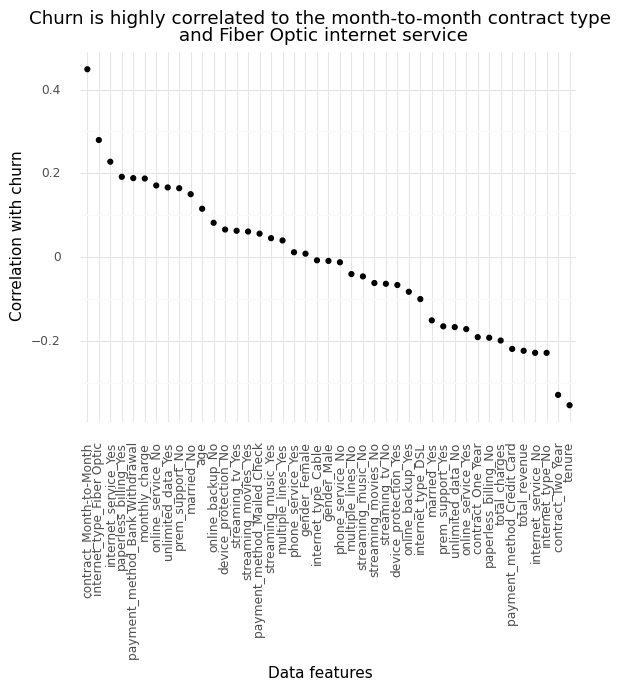

<ggplot: (142056816445)>

In [13]:
plot_corr

### Churn status by contract type

In [14]:
(
    cleaned_df
    .groupby(['contract'])
    .churn_status
    .value_counts()
)

contract         
Month-to-Month  0    1955
                1    1655
One Year        0    1384
                1     166
Two Year        0    1835
                1      48
Name: churn_status, dtype: int64

In [15]:
plot_contract = (
    pn.ggplot(cleaned_df,
              pn.aes(x = 'contract',
                     fill = 'churn_status'
                    )
             )
    + pn.geom_bar()
    + pn.geom_text(pn.aes(label=pn.after_stat('prop_per_x(x,count)*100')),
                   stat = 'count',
                   va = 'top',
                   ha = 'center',
                   format_string='{:.1f}%',
                   position = pn.position_stack(vjust=0.5)
                  )
    + pn.scale_fill_manual(values = (green,red))
    + pn.theme_minimal()
    + pn.ggtitle('Customers with month-to-month contract are more likely to churn')
    + pn.labs(x = 'Contract type', y = 'Count', fill = 'Churn Status')
)

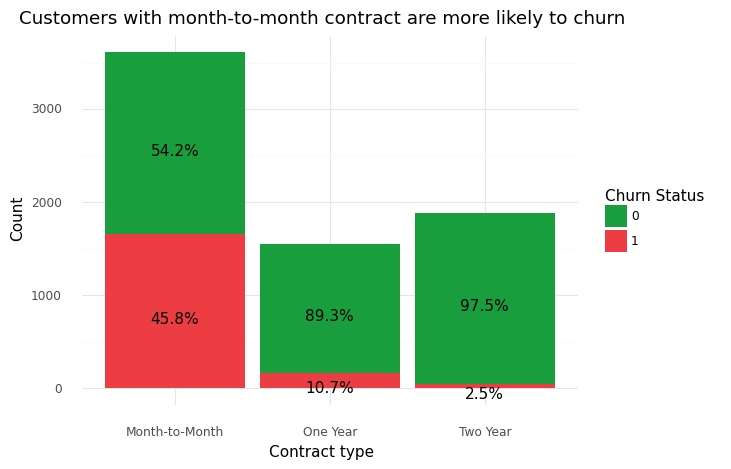

<ggplot: (142057442012)>

In [16]:
plot_contract

### Churn by internet type

In [17]:
(
    cleaned_df
    .groupby(['internet_type'])
    .churn_status
    .value_counts()
)

internet_type   
Cable          0     617
               1     213
DSL            0    1345
               1     307
Fiber Optic    0    1799
               1    1236
No             0    1413
               1     113
Name: churn_status, dtype: int64

In [18]:
plot_internet_type = (
    pn.ggplot(cleaned_df,
              pn.aes(x = 'internet_type',
                     fill = 'churn_status'
                    )
             )
    + pn.geom_bar()
    + pn.geom_text(pn.aes(label=pn.after_stat('prop_per_x(x,count)*100')),
                   stat = 'count',
                   va = 'top',
                   ha = 'center',
                   format_string='{:.1f}%',
                   position = pn.position_stack(vjust=0.5)
                  )
    + pn.scale_fill_manual(values = (green,red))
    + pn.scale_x_discrete(limits = ['Fiber Optic', 'DSL', 'Cable', 'No'])
    + pn.theme_minimal()
    + pn.ggtitle('Customers with Fiber Optics internet are more likely to churn')
    + pn.labs(x = 'Internet type', y = 'Count', fill = 'Churn Status')
)

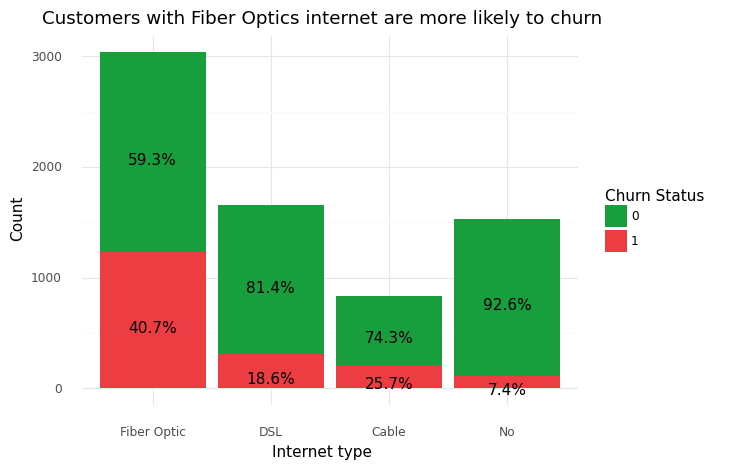

<ggplot: (142057493245)>

In [19]:
plot_internet_type

### Churn density by the monthly charge

In [20]:
(
    cleaned_df
    .loc[:,['churn_status','monthly_charge', 'total_charges','total_revenue']]
    .groupby('churn_status')
    .mean()
)

,monthly_charge,total_charges,total_revenue
churn_status,,,
0,60.073618,2550.792103,3418.374927
1,73.347592,1531.796094,1971.353569


In [21]:
plot_monthly_charge = (
    pn.ggplot(cleaned_df,pn.aes(x = 'monthly_charge'))
    + pn.geom_density(pn.aes(fill = 'churn_status'), alpha = 0.9)
    + pn.scale_fill_manual(values = (green,red))
    + pn.theme_minimal()
    + pn.ggtitle('Customers with higher monthly charges are more likely to churn')
    + pn.labs(x = 'Monthly Charge ($)', y = 'Density', fill = 'Churn status')
)

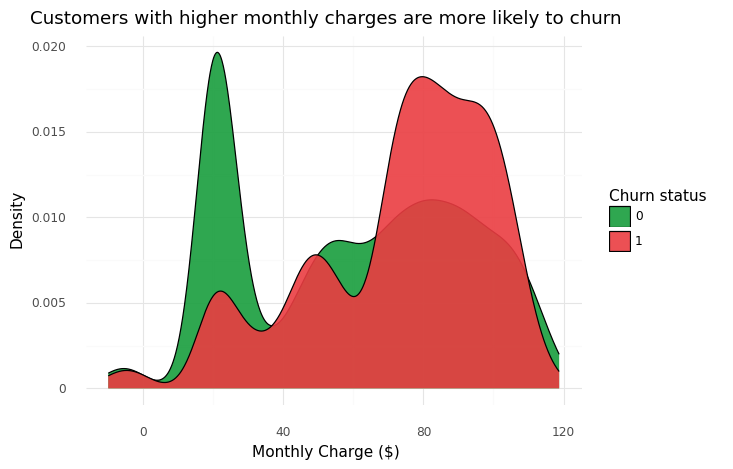

<ggplot: (142057678002)>

In [22]:
plot_monthly_charge

### Variation of monthly charges with internet type

Fiber optics customers have a higher monthly charge. Hence, we see high churn for both customers of fiber optics and those with high monthly charge.

In [23]:
(
    cleaned_df
    .loc[:,['internet_type','monthly_charge','churn_status']]
    .groupby(['internet_type','churn_status'])
    .agg(['count', 'mean'])
)

monthly_charge           
                                    count       mean
internet_type churn_status                          
Cable         0                       617  59.123258
              1                       213  60.027700
DSL           0                      1345  58.785725
              1                       307  48.059935
Fiber Optic   0                      1799  92.294747
              1                      1236  86.833576
No            0                      1413  20.691295
              1                       113  19.646460

In [24]:
plot_fiber_charge = (
    pn.ggplot(cleaned_df,
              pn.aes(x = 'internet_type', y = 'monthly_charge', fill = 'churn_status')
             )
    + pn.geom_boxplot(outlier_shape = '.',
                      outlier_size = 0.5
                     )
    + pn.scale_fill_manual(values = (green,red))
    + pn.theme_minimal()
    + pn.scale_x_discrete(limits = ['Fiber Optic', 'DSL', 'Cable', 'No'])
    + pn.labs(x = 'Internet Type', y = 'Monthly charge ($)', fill = 'Churn Status')
    + pn.ggtitle('Fiber Optics customers have a high monthly charge')
)

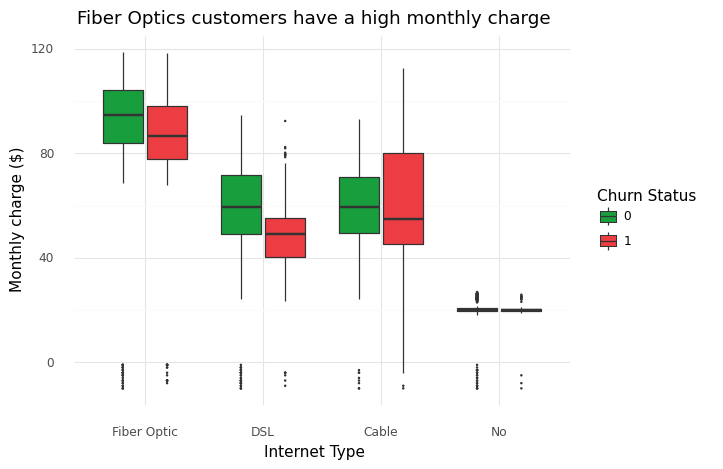

<ggplot: (142057732343)>

In [25]:
plot_fiber_charge

In [26]:
# Checking if there is a lurking relationship between contract type and internet type
(
    cleaned_df
    .groupby(['internet_type'])
    .contract
    .value_counts()
)

internet_type  contract      
Cable          Month-to-Month     423
               Two Year           216
               One Year           191
DSL            Month-to-Month     787
               Two Year           459
               One Year           406
Fiber Optic    Month-to-Month    1882
               One Year           587
               Two Year           566
No             Two Year           642
               Month-to-Month     518
               One Year           366
Name: contract, dtype: int64

# 4. Data analysis

- We will use the decision tree (A) and the XGB boast classifiers (B) to develop two seperate model
- The models will be tuned using gridsearch cross-validation to get the best estimator model
- These best models will be trained on 75% of the dataset and tested on 25% of the test data
- We will compare the accuracy of performance for both the algorithms to make the final selection of the model

### Setting up the variable matrices

In [27]:
# Creating the X and y matrices. We are not using the patsy dmatrices method given the large number of predictor variables.
y = cleaned_df.iloc[:,-1]
X = pd.get_dummies(cleaned_df.iloc[:,:-1]) #get_dummies helps convert the discrete variables to 0s and 1s

In [28]:
y.head()
X.head()

0    0
1    0
2    1
3    1
4    1
Name: churn_status, dtype: category
Categories (2, int64): [0, 1]

,age,tenure,monthly_charge,total_charges,total_revenue,gender_Female,gender_Male,married_No,married_Yes,phone_service_No,...,unlimited_data_No,unlimited_data_Yes,contract_Month-to-Month,contract_One Year,contract_Two Year,paperless_billing_No,paperless_billing_Yes,payment_method_Bank Withdrawal,payment_method_Credit Card,payment_method_Mailed Check
0,37,9,65.6,593.30,974.81,1,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0
1,46,9,-4.0,542.40,610.28,0,1,1,0,0,...,1,0,1,0,0,1,0,0,1,0
2,50,4,73.9,280.85,415.45,0,1,1,0,0,...,0,1,1,0,0,0,1,1,0,0
3,78,13,98.0,1237.85,1599.51,0,1,0,1,0,...,0,1,1,0,0,0,1,1,0,0
4,75,3,83.9,267.40,289.54,1,0,0,1,0,...,0,1,1,0,0,0,1,0,1,0


## A. Decision Tree

In [29]:
# Creating a parameter grid for the model tuning
param_grid = {
    'max_leaf_nodes' : [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_leaf' : [1, 4, 9, 16, 25, 36, 49]
}

# Defining the base model for the cross validation
tree_model = sklearn.tree.DecisionTreeClassifier()

In [30]:
# Running the grid search with 10 fold cross validation
tree_gridsearch = sklearn.model_selection.GridSearchCV(
    tree_model,
    param_grid = param_grid,
    cv = 10
)

In [31]:
# Fitting the grid search to the data
tree_gridsearch.fit(X, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 40],
                         'min_samples_leaf': [1, 4, 9, 16, 25, 36, 49]})

### Visualizing the performance of the gridsearch for Decision Tree

In [32]:
tree_cv_perf_df = pd.DataFrame(tree_gridsearch.cv_results_)
tree_cv_perf_df.param_max_leaf_nodes = tree_cv_perf_df.param_max_leaf_nodes.astype('int')

In [33]:
plot_tree_cv_perf = (
    pn.ggplot(tree_cv_perf_df,
              pn.aes(x = 'param_max_leaf_nodes', y = 'mean_test_score', color = 'param_min_samples_leaf')
             )
    + pn.geom_point()
    + pn.geom_line()
    + pn.theme_minimal()
    + pn.labs(x = 'Max leaf nodes', y = 'Mean test scores', color = 'Min samples per leaf')
)

- The performance of the model intially improves with max_leaf_nodes and then starts detereorating after ~20 nodes
- Moderate min_sample_leafs (~25) perform better than lower or higher minimum samples per leaf

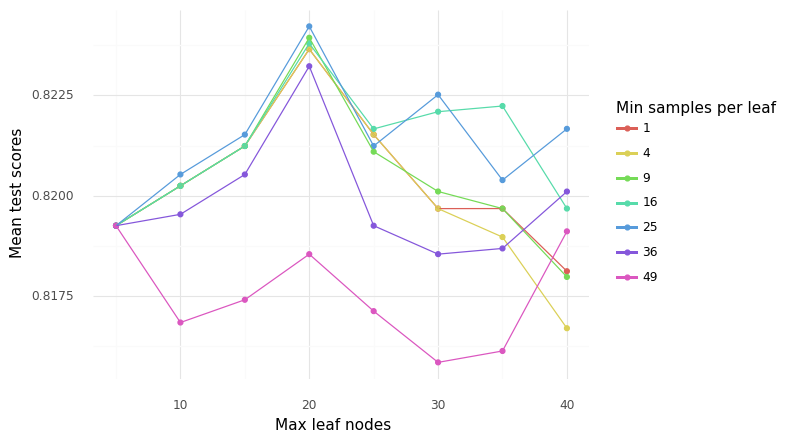

<ggplot: (142057498353)>

In [34]:
plot_tree_cv_perf

### Testing the out-of-sample accuracy of the best decision tree model

In [35]:
# Getting the best decision tree
tree_best = tree_gridsearch.best_estimator_

In [36]:
# Splitting the data to get the train (75%) and test set (25%)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.25, random_state = 99)
tree_best.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=20, min_samples_leaf=25)

In [37]:
# Getting the accuracy score for out-of-sample data
tree_best_accuracy = sklearn.metrics.accuracy_score(y_test, tree_best.predict(X_test))
print('The out-of-sample accuracy of the decision tree model is {:.2%}'.format(tree_best_accuracy))

The out-of-sample accuracy of the decision tree model is 81.71%


### Top 10 features of the decision tree model

- Month to month contract type and Fiber Optic internet service are among the top 10 features for the model
- Need to further investigate the relationship of age with churn in the next steps

In [38]:
tree_top10_feature_df = (
    pd.DataFrame({'Feature': tree_best.feature_names_in_,
                  'Importance': tree_best.feature_importances_}
                )
    .sort_values(by = 'Importance', ascending= False)
    .head(10)
)
tree_top10_feature_df['Feature'] = pd.Categorical(tree_top10_feature_df.Feature, categories=pd.unique(tree_top10_feature_df.Feature.iloc[::-1]), ordered=True)

In [39]:
plot_tree_top10_feature = (
    pn.ggplot(tree_top10_feature_df,
              pn.aes(y = 'Feature', x = 'Importance')
             )
    + pn.geom_point()
    + pn.theme(axis_text_x=pn.element_text(angle = 90))
    + pn.theme_minimal()
)

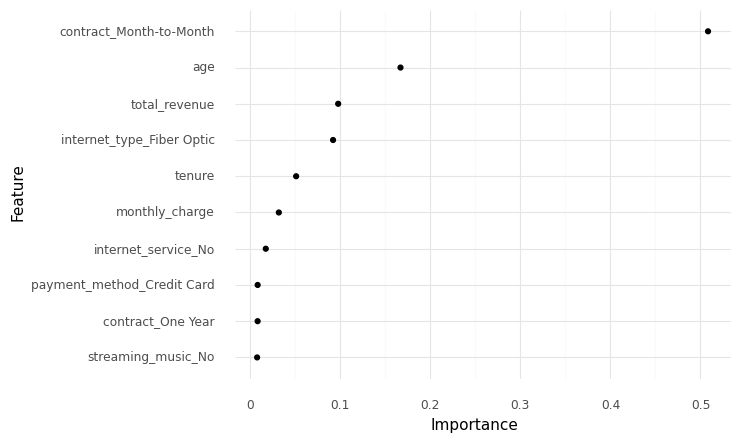

<ggplot: (142056819435)>

In [40]:
plot_tree_top10_feature

## B. XGB Classifier

In [62]:
# Creating a parameter grid to tune the XGB model
param_grid = {
    'max_depth': range (5, 20, 5),
    'n_estimators': range(50, 200, 50),
    'learning_rate': [.001, .01, .1]
}

In [63]:
# Setting up a base XGB classifier model
xgb_model = xgb.XGBClassifier()

# Gridsearch for the best xgb model with 5 fold cross-validation
xgb_gridsearch = sklearn.model_selection.GridSearchCV(xgb_model,
                                                      param_grid = param_grid,
                                                      cv = 5,
                                                      n_jobs=-1
                                                     )

# Fitting the gridsearch to the data
xgb_gridsearch.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=Non

### Visualizing the performance of the gridsearch for XGB

In [64]:
xgb_cv_perf_df = pd.DataFrame(xgb_gridsearch.cv_results_)
xgb_cv_perf_df.param_max_depth = xgb_cv_perf_df.param_max_depth.astype(int)

In [65]:
plot_xgb_cv_perf = (
    pn.ggplot(xgb_cv_perf_df,
              pn.aes(x = 'param_max_depth', y = 'mean_test_score', color = 'param_learning_rate')
             )
    + pn.geom_point()
    + pn.geom_line()
    + pn.facet_wrap('param_n_estimators', labeller = 'label_both')
    + pn.theme_minimal()
    + pn.labs(x = 'Max depth', y = 'Mean test scores', color = 'Learning rate')

)

- Model performance is best at max depth of 5, learning rate of 0.1, and 50 estimators
- The performance detereorates on further increase in the parameters

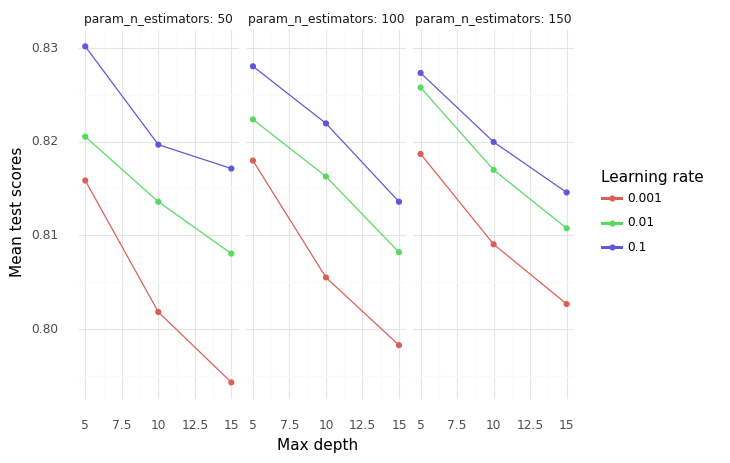

<ggplot: (142058177636)>

In [66]:
plot_xgb_cv_perf

### Testing the out-of-sample accuracy of the best XGB model

In [67]:
# Getting the best estimator model from the gridsearch
xgb_best = xgb_gridsearch.best_estimator_

In [68]:
# Splitting the data to get the train (75%) and test set (25%)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.25, random_state = 99)
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [69]:
# Getting the accuracy for the out-of-sample data
xgb_best_accuracy = sklearn.metrics.accuracy_score(xgb_best.predict(X_test), y_test)
print('The out-of-sample accuracy of the best xgb model is {:.2%}'.format(xgb_best_accuracy))

The out-of-sample accuracy of the best xgb model is 82.74%


### Top 10 features of the XGB model

- Monthly charge and age are the top 2 features for the XGB model
- Need to investigate the impact of the fiber optics service based on the exploration done above

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

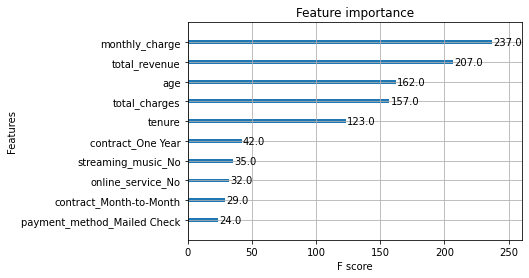

In [70]:
xgb.plot_importance(xgb_best, max_num_features=10)

In [ ]:
import matplotlib

In [ ]:
xgb.plot_tree(xgb_best)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(300, 200)

In [ ]:
fig.savefig('xgb_tree.png')

# 5. Next Steps

A. What benefits do you anticipate for your stakeholders?
B. What are the resources required? How will those resources be allocated?
a. Your time costs, in full-time-equivalent (FTE) months?
b. Total human annotation costs, annotator FTE months and monthly wage
c. Total engineering costs, professional programmer FTE months and wage
d. Additional monetary costs (e.g., data purchase)
e. If nontrivial: total storage (GB), RAM (GB), computation (core-hours)
C. What are the data inputs for this ideal analysis?
D. What is the planned output for this ideal analysis? Be as specific as possible.
E. What is your strategy for transforming inputs into outputs? Be as specific as possible.
F. What problems do you anticipate? What are your plans for addressing them?